<a href="https://colab.research.google.com/github/A-Wadhwani/CS390-Lab2/blob/master/CS390_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import random

random.seed(1618)
np.random.seed(1618)
# tf.set_random_seed(1618)   # Uncomment for TF1.
tf.random.set_seed(1618)

# tf.logging.set_verbosity(tf.logging.ERROR)   # Uncomment for TF1.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ALGORITHM = "guesser"
# ALGORITHM = "tf_net"
ALGORITHM = "tf_conv"

# DATASET = "mnist_d"
# DATASET = "mnist_f"
# DATASET = "cifar_10"
# DATASET = "cifar_100_f"
DATASET = "cifar_100_c"

if DATASET == "mnist_d":
    NUM_CLASSES = 10
    IH = 28
    IW = 28
    IZ = 1
    IS = 784
elif DATASET == "mnist_f":
    NUM_CLASSES = 10
    IH = 28
    IW = 28
    IZ = 1
    IS = 784
elif DATASET == "cifar_10":
    NUM_CLASSES = 10
    IH = 32
    IW = 32
    IZ = 3
    IS = 3072
elif DATASET == "cifar_100_f":
    NUM_CLASSES = 100
    IH = 32
    IW = 32
    IZ = 3
    IS = 3072
elif DATASET == "cifar_100_c":
    NUM_CLASSES = 20
    IH = 32
    IW = 32
    IZ = 3
    IS = 3072


# =========================<Classifier Functions>================================

def guesserClassifier(xTest):
    ans = []
    for entry in xTest:
        pred = [0] * NUM_CLASSES
        pred[random.randint(0, 9)] = 1
        ans.append(pred)
    return np.array(ans)


def buildTFNeuralNet(x, y, eps=20):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.sigmoid),
        tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x, y, epochs=eps, batch_size=128)
    return model


def buildTFConvNet(x, y, eps=10, dropout=True, dropRate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,
                               kernel_size=(3, 3),
                               activation=tf.nn.relu,
                               input_shape=(IH, IW, IZ)),
        tf.keras.layers.Conv2D(32,
                               kernel_size=(2, 2),
                               activation=tf.nn.relu),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dropout(dropRate if dropout else 0.0),

        tf.keras.layers.Conv2D(64,
                               kernel_size=(3, 3),
                               activation=tf.nn.relu),
        tf.keras.layers.Conv2D(64,
                               kernel_size=(2, 2),
                               activation=tf.nn.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax)
    ])

    def scheduler(epoch, lr):
        if epoch < 3:
            return 0.001
        elif epoch < 5:
            return 0.0005
        elif epoch < 7:
            return 0.0001
        elif epoch < 9:
            return 0.00005
        return 0.00001

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
    model.fit(x, y, epochs=eps, callbacks=[reduce_lr], batch_size=64)
    return model


# =========================<Pipeline Functions>==================================

def getRawData():
    if DATASET == "mnist_d":
        mnist = tf.keras.datasets.mnist
        (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    elif DATASET == "mnist_f":
        mnist = tf.keras.datasets.fashion_mnist
        (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    elif DATASET == "cifar_10":
        cifar = tf.keras.datasets.cifar10
        (xTrain, yTrain), (xTest, yTest) = cifar.load_data()
    elif DATASET == "cifar_100_f":
        cifar = tf.keras.datasets.cifar100
        (xTrain, yTrain), (xTest, yTest) = cifar.load_data(label_mode='fine')
    elif DATASET == "cifar_100_c":
        cifar = tf.keras.datasets.cifar100
        (xTrain, yTrain), (xTest, yTest) = cifar.load_data(label_mode='coarse')
    else:
        raise ValueError("Dataset not recognized.")
    print("Dataset: %s" % DATASET)
    print("Shape of xTrain dataset: %s." % str(xTrain.shape))
    print("Shape of yTrain dataset: %s." % str(yTrain.shape))
    print("Shape of xTest dataset: %s." % str(xTest.shape))
    print("Shape of yTest dataset: %s." % str(yTest.shape))
    return ((xTrain, yTrain), (xTest, yTest))


def preprocessData(raw):
    ((xTrain, yTrain), (xTest, yTest)) = raw
    if ALGORITHM != "tf_conv":
        xTrainP = xTrain.reshape((xTrain.shape[0], IS))
        xTestP = xTest.reshape((xTest.shape[0], IS))
    else:
        xTrainP = xTrain.reshape((xTrain.shape[0], IH, IW, IZ))
        xTestP = xTest.reshape((xTest.shape[0], IH, IW, IZ))
    yTrainP = to_categorical(yTrain, NUM_CLASSES)
    yTestP = to_categorical(yTest, NUM_CLASSES)
    xTrainP = xTrainP / 255.
    xTestP = xTestP / 255.
    print("New shape of xTrain dataset: %s." % str(xTrainP.shape))
    print("New shape of xTest dataset: %s." % str(xTestP.shape))
    print("New shape of yTrain dataset: %s." % str(yTrainP.shape))
    print("New shape of yTest dataset: %s." % str(yTestP.shape))
    return ((xTrainP, yTrainP), (xTestP, yTestP))


def trainModel(data):
    xTrain, yTrain = data
    if ALGORITHM == "guesser":
        return None  # Guesser has no model, as it is just guessing.
    elif ALGORITHM == "tf_net":
        print("Building and training TF_NN.")
        return buildTFNeuralNet(xTrain, yTrain)
    elif ALGORITHM == "tf_conv":
        print("Building and training TF_CNN.")
        return buildTFConvNet(xTrain, yTrain)
    else:
        raise ValueError("Algorithm not recognized.")


def runModel(data, model):
    if ALGORITHM == "guesser":
        return guesserClassifier(data)
    elif ALGORITHM == "tf_net":
        print("Testing TF_NN.")
        preds = model.predict(data)
        for i in range(preds.shape[0]):
            oneHot = [0] * NUM_CLASSES
            oneHot[np.argmax(preds[i])] = 1
            preds[i] = oneHot
        return preds
    elif ALGORITHM == "tf_conv":
        print("Testing TF_CNN.")
        preds = model.predict(data)
        for i in range(preds.shape[0]):
            oneHot = [0] * NUM_CLASSES
            oneHot[np.argmax(preds[i])] = 1
            preds[i] = oneHot
        return preds
    else:
        raise ValueError("Algorithm not recognized.")


def evalResults(data, preds):
    xTest, yTest = data
    acc = 0
    for i in range(preds.shape[0]):
        if np.array_equal(preds[i], yTest[i]):   acc = acc + 1
    accuracy = acc / preds.shape[0]
    print("Classifier algorithm: %s" % ALGORITHM)
    print("Classifier accuracy: %f%%" % (accuracy * 100))
    print()
    return accuracy * 100


# =========================<Main>================================================

def main():
    raw = getRawData()
    data = preprocessData(raw)
    model = trainModel(data[0])
    preds = runModel(data[1][0], model)
    evalResults(data[1], preds)


if __name__ == '__main__':
    main()


Dataset: cifar_100_c
Shape of xTrain dataset: (50000, 32, 32, 3).
Shape of yTrain dataset: (50000, 1).
Shape of xTest dataset: (10000, 32, 32, 3).
Shape of yTest dataset: (10000, 1).
New shape of xTrain dataset: (50000, 32, 32, 3).
New shape of xTest dataset: (10000, 32, 32, 3).
New shape of yTrain dataset: (50000, 20).
New shape of yTest dataset: (10000, 20).
Building and training TF_CNN.
Epoch 1/10


KeyboardInterrupt: ignored

In [20]:
def runAlg():
  global NUM_CLASSES
  global IH
  global IW
  global IZ
  global IS
  if DATASET == "mnist_d":
      NUM_CLASSES = 10
      IH = 28
      IW = 28
      IZ = 1
      IS = 784
  elif DATASET == "mnist_f":
      NUM_CLASSES = 10
      IH = 28
      IW = 28
      IZ = 1
      IS = 784
  elif DATASET == "cifar_10":
      NUM_CLASSES = 10
      IH = 32
      IW = 32
      IZ = 3
      IS = 3072
  elif DATASET == "cifar_100_f":
      NUM_CLASSES = 100
      IH = 32
      IW = 32
      IZ = 3
      IS = 3072
  elif DATASET == "cifar_100_c":
      NUM_CLASSES = 20
      IH = 32
      IW = 32
      IZ = 3
      IS = 3072
  raw = getRawData()
  data = preprocessData(raw)
  model = trainModel(data[0])
  preds = runModel(data[1][0], model)
  return evalResults(data[1], preds)

In [21]:
df = {}
for i in ["tf_net", "tf_conv"]:
  global ALGORITHM
  ALGORITHM  = i
  df1 = {}
  for j in ["mnist_d", "mnist_f", "cifar_10", "cifar_100_f", "cifar_100_c"]:
    global DATASET
    DATASET = j
    df1[j] = runAlg()
  df[i] = df1
print(df)

Dataset: mnist_d
Shape of xTrain dataset: (60000, 28, 28).
Shape of yTrain dataset: (60000,).
Shape of xTest dataset: (10000, 28, 28).
Shape of yTest dataset: (10000,).
New shape of xTrain dataset: (60000, 784).
New shape of xTest dataset: (10000, 784).
New shape of yTrain dataset: (60000, 10).
New shape of yTest dataset: (10000, 10).
Building and training TF_NN.
Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.5183 - accuracy: 0.8702
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2571 - accuracy: 0.9269
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2035 - accuracy: 0.9413
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1674 - accuracy: 0.9514
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1404 - accuracy: 0.9599
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1193 - accuracy: 0.9656
Epoch 7/20
469/469 [==============

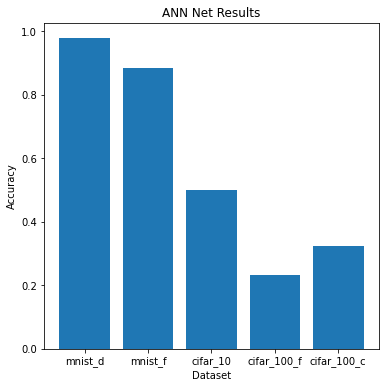

<Figure size 432x288 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.bar(df['tf_net'].keys(), df['tf_net'].values())
plt.title("ANN Net Results")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.show()

plt.savefig('ANN_Accuracy_Plot.pdf')